## Body Language Analysis

In [75]:
import warnings
import xlsxwriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib.pyplot
warnings.filterwarnings('ignore')

In [76]:
# Read the data
experiment_file_path = '../data/experiment-new.csv'
df_experiment = pd.read_csv(experiment_file_path)

In [77]:
# Clean the data # Clean the scores
df_experiment.columns = [c.replace(' ', '_') for c in df_experiment.columns]
df_experiment.Score = df_experiment.Score.map(lambda x: int(x[0]))
df_experiment.Score3 = df_experiment.Score3.map(lambda x: int(x[0]))

# Rename some columns for convenience
df_experiment['Country'] = df_experiment['1.1_Which_country_are_you_from?']
df_experiment['Gender'] = df_experiment['1.2_Please_choose_your_gender']
df_experiment.drop(columns=['1.1_Which_country_are_you_from?', '1.2_Please_choose_your_gender'], inplace=True)

# Filter out the rows required
retain_cols = ['Country', 'Gender', 'Age', 'Calc', 'Calc2', 'Calc3', 'Calc4', 'Calc5', 'Calc6', 'Calc7', 'Calc8', 'Score', 'Calc9', 'Calc10', 'Calc11', 'Calc12', 'Calc13', 'Calc14', 'Score3']
df_experiment = df_experiment.filter(items=retain_cols, axis='columns')

In [78]:
display(df_experiment.sample(5))

,Country,Gender,Age,Calc,Calc2,Calc3,Calc4,Calc5,Calc6,Calc7,Calc8,Score,Calc9,Calc10,Calc11,Calc12,Calc13,Calc14,Score3
33,Israel,Male,28,-3,-1,-2,-1,0,4,1,0,1,-1,-1,-1,-1,2,0,2
47,India,Male,28,0,1,1,0,0,0,0,1,3,0,1,-2,0,1,0,3
22,India,Male,31,0,0,0,0,0,1,1,1,3,0,0,0,0,0,-1,3
27,India,Male,26,1,0,0,0,1,2,2,2,3,-2,-1,0,-1,-1,-1,2
28,Germany,Male,33,0,0,1,0,-2,-1,1,-1,6,0,0,-1,1,0,0,3


In [79]:
# Helper functions
# Functions to calculate the the user's awareness before and after the survey
# Each respondent is assigned a value True/False based on their answers, before and after the survey
def taboo_rating(row):
    count = 0
    if(row['Calc'] > 0):
        count+=1
    if(row['Calc2'] > 0):
        count+=1
    if(row['Calc3'] > 0):
        count+=1
    if(row['Calc4'] > 0):
        count+=1
    if(row['Calc5'] > 0):
        count+=1
    if(row['Calc6'] > 0):
        count+=1
    if(row['Calc7'] > 0):
        count+=1
    if(row['Calc8'] > 0):
        count+=1
    if(count >= 2):
        return True
    else: 
        return False
    
def body_lang_rating(row):
    count = 0
    if(row['Calc9'] > 0):
        count+=1
    if(row['Calc10'] > 0):
        count+=1
    if(row['Calc11'] > 0):
        count+=1
    if(row['Calc12'] > 0):
        count+=1
    if(row['Calc13'] > 0):
        count+=1
    if(row['Calc14'] > 0):
        count+=1
    if(count >= 2):
        return True
    else: 
        return False
    
def calculate_vector_diff(df_col):
    nor_sum = df_col.sum()
    abs_sum = df_col.abs().sum()
    return abs_sum - nor_sum

def calculate_percentage_country(subject_dataframe, country_total):
    x_ticks = []
    y_ticks = []
    aware_countries, num = subject_dataframe.Country.value_counts().index, subject_dataframe.Country.value_counts()
    for c, n in zip(aware_countries, num):
        x_ticks.append(c)
        y_ticks.append(round((n/country_total.get(c))*100))
    return (x_ticks, y_ticks) 

### Investigating user awareness

We find the answers that have been poorly performed by users overall. With these specific questions we further identify the users whose awareness is high and low. With a threshold of {-2 <= awareness <= 2}. Finally, we group these users by country and 

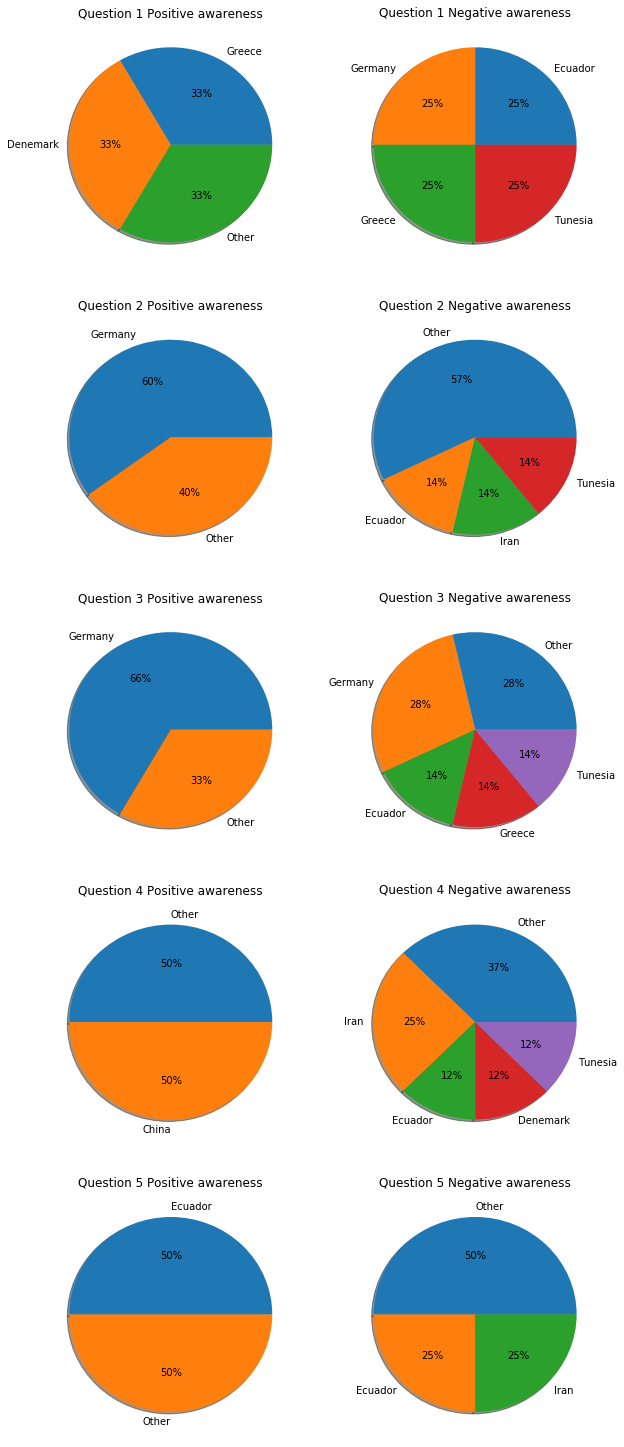

In [115]:
# Find the vector difference for Calc sum and absolute sum, and pull values above a threshold
shortlisted_cols = []
all_cols = ['Calc', 'Calc2', 'Calc3', 'Calc4', 'Calc5', 'Calc6', 'Calc7', 'Calc8', 'Calc9', 'Calc10', 'Calc11', 'Calc12', 'Calc13', 'Calc14']
for c in all_cols:
    if (calculate_vector_diff(df_experiment[c]) >= 60):
        shortlisted_cols.append(c)


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,26))
writer = pd.ExcelWriter('../data/calc-pos-neg.xlsx', engine='xlsxwriter')
i = 0
for each in ("Calc2", 'Calc9', 'Calc10', 'Calc11', 'Calc13'):
    df_pos = df_experiment.loc[(df_experiment[each] >= 2) & ~(df_experiment['Country'].isin(['India', 'Pakistan ', 'Bangaladesh', 'Srilanka']))]
    df_neg = df_experiment.loc[(df_experiment[each] <= -2) & ~(df_experiment['Country'].isin(['India', 'Pakistan ', 'Bangaladesh', 'Srilanka']))]
    axes[i, 0].pie(x=df_pos.Country.value_counts(), labels=df_pos.Country.value_counts().index, shadow=True, autopct='%1d%%')
    axes[i, 0].set_title('Question ' + str(i + 1) + ' Positive awareness')
    axes[i, 1].pie(x=df_neg.Country.value_counts(), labels=df_neg.Country.value_counts().index, shadow=True, autopct='%1d%%')
    axes[i, 1].set_title('Question ' + str(i + 1) + ' Negative awareness')
    i += 1
fig.savefig('positive-negative-awareness.eps', dpi=5000)

In [82]:
# Group single respondents from a particular country into a group called 'Other'
num, country = df_experiment.Country.value_counts(), df_experiment.Country.value_counts().index
countries_with_single_respondent = []
for c, n in zip(country, num):
    if(n == 1):
        countries_with_single_respondent.append(c)
df_experiment.Country.replace(to_replace=countries_with_single_respondent, value='Other', inplace=True)
num, country = df_experiment.Country.value_counts(), df_experiment.Country.value_counts().index # update values
# Store the total number of respondents grouped by country
country_total = dict((c, n) for c, n in zip(country, num))

In [83]:
# How many countries answered the survey

countries = df_experiment['Country']
print("Total number of participants: ", countries.count())

Total number of participants:  61


### Number of survey respondents grouped by Country

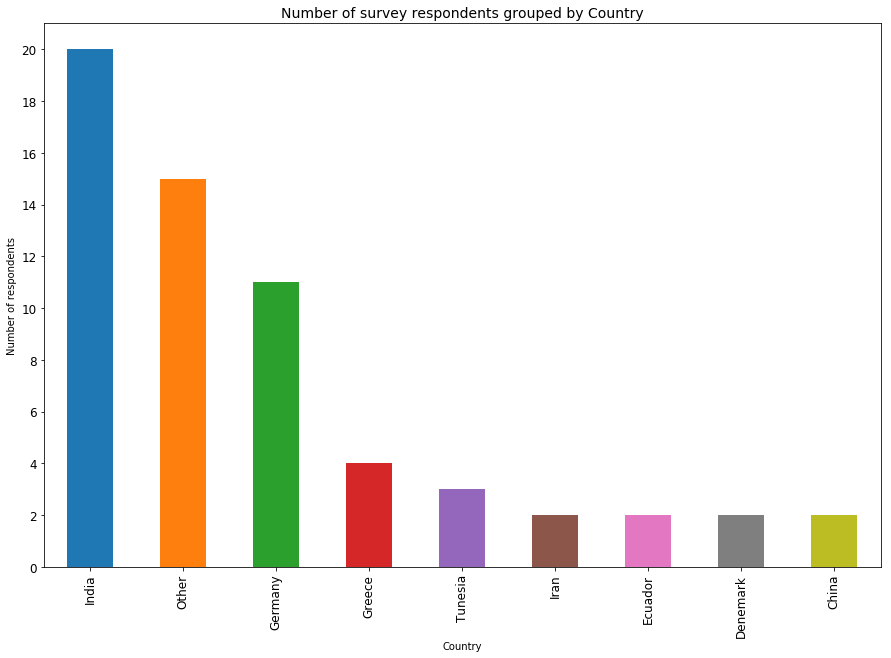

In [84]:
# Number of respondents, grouped by country
fig = plt.figure()
props = {
    'title' : 'Number of survey respondents grouped by Country',
    'yticks' : range(0,22,2),
    'figsize' : (15, 10),
    'fontsize' : 12
}
ax = df_experiment['Country'].value_counts().plot.bar(**props)
ax.set_xlabel('Country')
ax.set_ylabel('Number of respondents')
ax = fig.add_subplot(ax)
ax.title.set_fontsize(14)
fig.savefig('respondents-per-country.eps', dpi=5000)

In [85]:
# score above 3 sorted by country

country_based_score = df_experiment[['Country', 'Score', 'Score3']]
country_based_score_greaterthan3 = country_based_score.loc[(country_based_score['Score'] > 3) | (country_based_score['Score3'] > 3)]
countries_count_score = country_based_score_greaterthan3['Country']

### Number of survey respondents with high awareness grouped by Country 

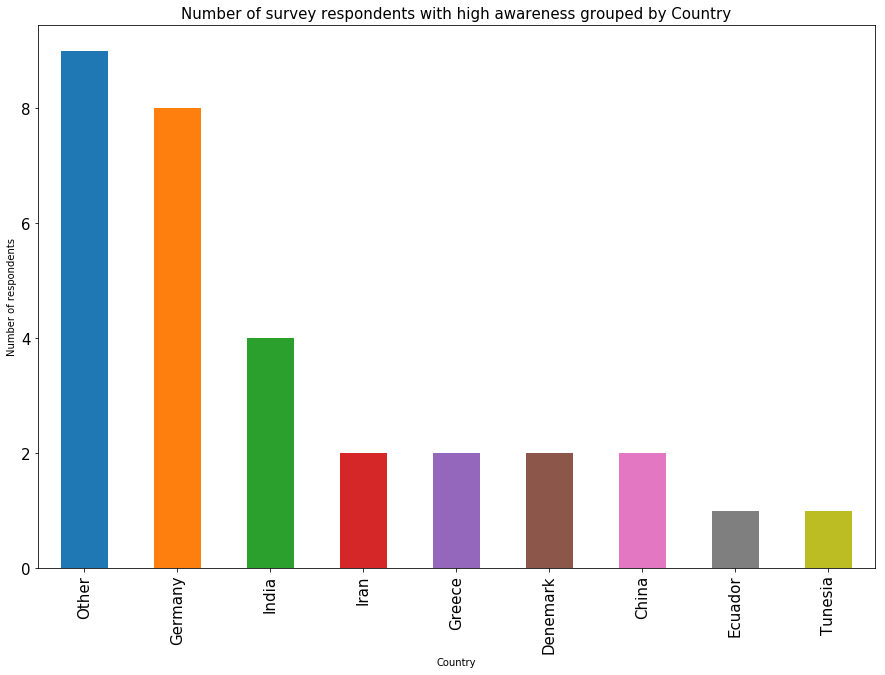

In [86]:
fig = plt.figure()
props = {
    'title' : 'Number of survey respondents with high awareness grouped by Country',
    'yticks' : range(0,10,2),
    'figsize' : (15, 10),
    'fontsize' : 15
}
ax = countries_count_score.value_counts().plot.bar(**props)
ax.set_xlabel('Country', fontsize=10)
ax.set_ylabel('Number of respondents')
ax = fig.add_subplot(ax)
ax.title.set_fontsize(15)
fig.savefig('increase-of-awareness-grouped-by-country.eps', dpi=5000)

In [87]:
# Score above 3 sorted by gender

gender_based_score = df_experiment[['Gender', 'Score', 'Score3']]
total_males = gender_based_score.loc[gender_based_score['Gender'] == "Male"]
total_males = total_males.count()
total_females = gender_based_score.loc[gender_based_score['Gender'] == "Female"]
total_females = total_females.count()

gender_based_score_greaterthan3 = gender_based_score.loc[(gender_based_score['Score'] > 3) | (gender_based_score['Score3'] > 3)]
gender_count_score = gender_based_score_greaterthan3['Gender']
print("Total number of people sorted by Gender: \n Males %d Females %d" %(total_males[1], total_females[1]) )
print("Score above 3 sorted by Gender:\n", gender_count_score.value_counts())

calculate_percentage_males = (26/total_males[1]) * 100
calculate_percentage_females = (5/total_females[1]) * 100
print("Percentage Males: %d%% Females: %d%%" %(calculate_percentage_males, calculate_percentage_females))

Total number of people sorted by Gender: 
 Males 50 Females 11
Score above 3 sorted by Gender:
 Male      26
Female     5
Name: Gender, dtype: int64
Percentage Males: 52% Females: 45%


### Percentange of people with high score, grouped by Gender

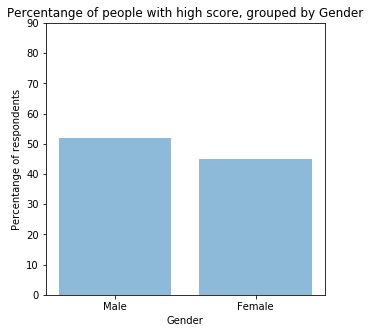

In [88]:
objects = ('Male', 'Female')
y_pos = np.arange(len(objects))
performance = [52, 45]
 
plt.figure(figsize=(5,5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentange of respondents')
plt.yticks(range(0,100,10))
plt.xlabel('Gender')
plt.title('Percentange of people with high score, grouped by Gender')
plt.savefig('highest-grade-gender.eps', dpi=5000)
plt.show()

In [89]:
# Applying the above functions and separating relavant data into df_taboo and df_bodylang
df_experiment['taboo_rating'] = df_experiment.apply(taboo_rating, axis=1)
df_experiment['body_lang_rating'] = df_experiment.apply(body_lang_rating, axis=1)

# Filter based on taboo rating and Score (positive)
df_taboo = df_experiment[['Country', 'Gender', 'Age', 'taboo_rating', 'Score']]
df_taboo = df_taboo.loc[(df_taboo['taboo_rating']) & (df_taboo['Score'] > 3)]

# Filter based on bodylang rating and Score (positive)
df_bodylang = df_experiment[['Country', 'Gender', 'Age', 'body_lang_rating', 'Score3']]
df_bodylang = df_bodylang.loc[(df_bodylang['body_lang_rating'] & (df_bodylang['Score3'] > 3))]

# Filter based on taboo rating and Score (negative)
df_taboo_neg = df_experiment[['Country', 'Gender', 'Age', 'taboo_rating', 'Score']]
df_taboo_neg = df_taboo_neg.loc[~(df_taboo_neg['taboo_rating']) & (df_taboo_neg['Score'] > 3)]

# Filter based on bodylang rating and Score (negative)
df_bodylang_neg = df_experiment[['Country', 'Gender', 'Age', 'body_lang_rating', 'Score3']]
df_bodylang_neg = df_bodylang_neg.loc[~(df_bodylang_neg['body_lang_rating']) & (df_bodylang_neg['Score3'] > 3)]

### Awareness of Taboo grouped by Country

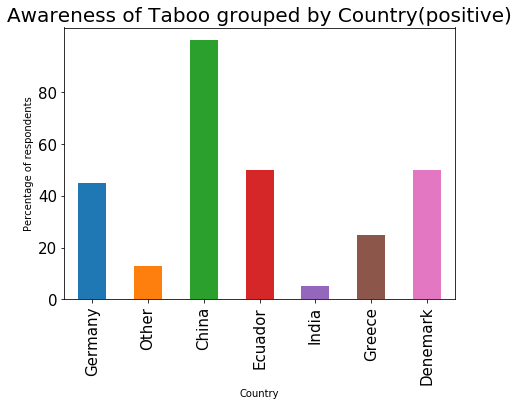

In [90]:
# Represent the above data Graphically including Indian-subcontinent
fig = plt.figure(figsize=(7,5))
x_ticks, y_ticks = calculate_percentage_country(df_taboo, country_total=country_total)
df_taboo_plot = pd.Series(y_ticks, index=x_ticks)
ax1 = df_taboo_plot.plot(kind='bar', title='Awareness of Taboo grouped by Country(positive)', yticks=range(0, 100, 20), fontsize=15)
ax1.set_ylabel('Percentage of respondents')
ax1.set_xlabel('Country')
ax1.title.set_size(20)
fig.add_subplot(ax1)
fig.show()
fig.savefig('awareness-taboo-positive.eps', dpi=5000)

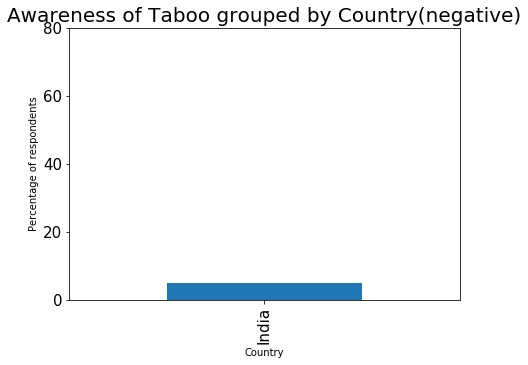

In [91]:
fig = plt.figure(figsize=(7,5))
x_ticks, y_ticks = calculate_percentage_country(df_taboo_neg, country_total=country_total)
df_taboo_plot = pd.Series(y_ticks, index=x_ticks)
ax = df_taboo_plot.plot(kind='bar', title='Awareness of Taboo grouped by Country(negative)', yticks=range(0, 100, 20), fontsize=15)
ax.set_ylabel('Percentage of respondents')
ax.set_xlabel('Country')
ax.title.set_size(20)
fig.add_subplot(ax)
fig.show()
fig.savefig('awareness-taboo-negative.eps', dpi=5000)

### Awareness of Body Language grouped by Country

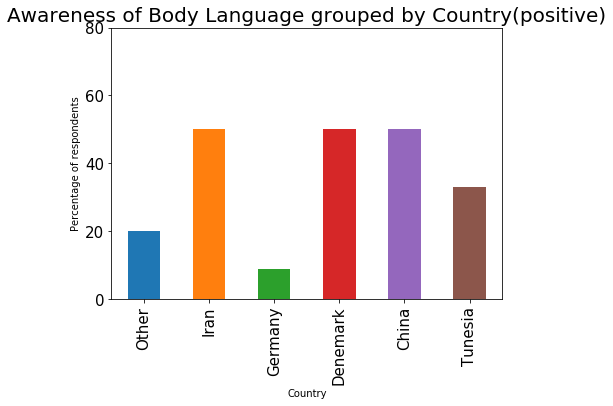

In [92]:
fig = plt.figure(figsize=(7,5))
x_ticks, y_ticks = calculate_percentage_country(df_bodylang, country_total=country_total)
df_bodylang_plot = pd.Series(y_ticks, index=x_ticks)
ax = df_bodylang_plot.plot(kind='bar', title='Awareness of Body Language grouped by Country(positive)', yticks=range(0, 100, 20), fontsize=15)
ax.set_ylabel('Percentage of respondents')
ax.set_xlabel('Country')
ax.title.set_size(20)
fig.add_subplot(ax)
fig.show()
fig.savefig('awareness-bodylang-positive.eps', dpi=5000)

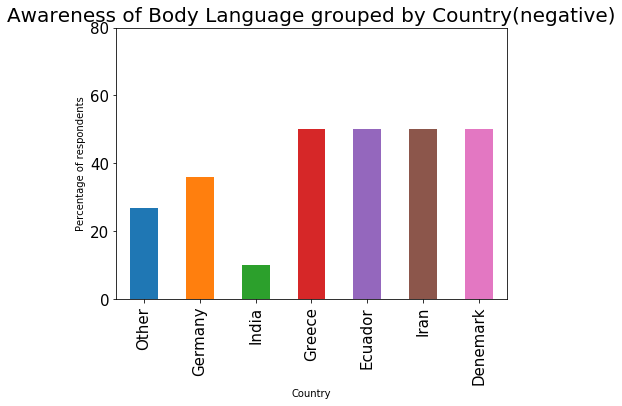

In [93]:
fig = plt.figure(figsize=(7,5))
x_ticks, y_ticks = calculate_percentage_country(df_bodylang_neg, country_total=country_total)
df_bodylang_plot = pd.Series(y_ticks, index=x_ticks)
ax = df_bodylang_plot.plot(kind='bar', title='Awareness of Body Language grouped by Country(negative)', yticks=range(0, 100, 20), fontsize=15)
ax.set_ylabel('Percentage of respondents')
ax.set_xlabel('Country')
ax.title.set_size(20)
fig.add_subplot(ax)
fig.show()
fig.savefig('awareness-bodylang-negative.eps', dpi=5000)

In [94]:
# separate India from dataframe
# compare calc values for them